# Chargement et concaténation des données S3

In [ ]:
import pandas as pd
import os
import s3fs
from dotenv import load_dotenv

load_dotenv()

In [ ]:
BUCKET_NAME = "tristant"
S3_PREFIX = "diffusion"
S3_ENDPOINT = os.getenv("AWS_S3_ENDPOINT", "minio.lab.sspcloud.fr")
S3_URL = f"https://{S3_ENDPOINT}"

storage_options = {
    "client_kwargs": {"endpoint_url": S3_URL}
}

In [ ]:
FILES = [
    "dfs_games.parquet",
    "games_blitz.parquet",
    "games_rapid.parquet",
    "games_bullet.parquet",
    "games_classical.parquet",
]


In [ ]:
def read_all_games_without_listing():
    dfs = []

    for file in FILES:
        s3_path = f"s3://{BUCKET_NAME}/{S3_PREFIX}/{file}"
        format_partie = file.replace("games_", "").replace(".parquet", "")

        try:
            df = pd.read_parquet(s3_path, storage_options=storage_options)

            if file.startswith("games_"):
                df["format_partie"] = format_partie

            dfs.append(df)
            print(f"✅ Lu : {s3_path}")

        except Exception as e:
            print(f"❌ Erreur sur {s3_path} : {e}")

    game_dfs = [df for df in dfs if "format_partie" in df.columns]

    if game_dfs:
        df_total = pd.concat(game_dfs, ignore_index=True)
        print(f"\nImport terminé : {len(df_total)} parties")
        return df_total
    else:
        return pd.DataFrame()


In [ ]:
df_all = read_all_games_without_listing()
df_all.head()

In [ ]:
df_all["timestamp_ms"] = df_all["timestamp"]
df_all["date"] = pd.to_datetime(df_all["timestamp_ms"], unit="ms", utc=True)
df_all.head()

# Remise en forme du dataframe

In [ ]:
# 1️⃣ Trier par joueur et par temps
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)

# 2️⃣ Créer la colonne binaire win
df_all["win"] = (df_all["result"] == "Win").astype(int)

# 3️⃣ Créer la colonne win_next par joueur
df_all["win_next"] = df_all.groupby("user_id")["win"].shift(-1)

# 4️⃣ Vérification rapide pour un joueur exemple
df_all[df_all["user_id"]=="alien_from_the_moon"][["timestamp","win","win_next"]]

On fait un shift(-1) car les parties les plus anciennes sont en haut du tableau. Un 1 en colonne Win_next veut dire que le joueur gagne la partie d'après (en comptant vers le bas).

In [59]:
import pandas as pd

# Filtrer les lignes où win_next est défini
df_valid = df_all.dropna(subset=["win_next"])

# Créer la table de contingence
transition_table = pd.crosstab(df_valid["win"], df_valid["win_next"])

# Ajouter les probabilités conditionnelles
transition_probs = transition_table.div(transition_table.sum(axis=1), axis=0)

print("Matrice de transition (counts) :")
print(transition_table)

print("\nMatrice de transition (probabilités) :")
print(transition_probs)


Matrice de transition (counts) :
win_next   0.0   1.0
win                 
0         1585  1968
1         1971  3615

Matrice de transition (probabilités) :
win_next       0.0       1.0
win                         
0         0.446102  0.553898
1         0.352846  0.647154


On remarque que la somme sur les colonnes donne bien 1 : il y a une cohérence des résultats.

In [60]:
correlation = df_all[["win","win_next"]].dropna().corr().iloc[0,1]
print("Corrélation Win N → Win N+1 :", correlation)

Corrélation Win N → Win N+1 : 0.09324117974483924


La corrélation entre une victoire et la suivante est légèrement positive.

In [61]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df_all["win"], df_all["win_next"])
chi2, p_value, _, _ = chi2_contingency(table)

print("p-value test χ² :", p_value)

p-value test χ² : 6.019480516121563e-19


Un test statistique de l'hypothèse de dépendance entre vcitoire N et victoire N-1 est significatif à 1% (car la p-value est inférieur à 0.01).

# Analyse par format de parties

In [66]:
df_all.groupby("format_partie").apply(
    lambda x: x.groupby("win")["win_next"].mean()
)

/tmp/ipykernel_14304/3339415686.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all.groupby("format_partie").apply(


win,0,1
format_partie,,
blitz,0.545924,0.619658
bullet,0.509146,0.643522
classical,0.654779,0.685300
rapid,0.532814,0.638473


In [83]:
from scipy.stats import chi2_contingency
import pandas as pd

# Filtrer les lignes valides (win_next non NaN)
df_valid = df_all.dropna(subset=["win_next"])

# Fonction pour calculer p-value χ² pour un sous-DataFrame
def chi2_pvalue(sub_df):
    table = pd.crosstab(sub_df["win"], sub_df["win_next"])
    if table.shape == (2,2):
        _, p_value, _, _ = chi2_contingency(table)
        return p_value
    else:
        return None  # si pas assez de données pour le test

# Calcul des p-values par format de partie
p_values_by_format = df_valid.groupby("format_partie").apply(chi2_pvalue)

print("Voici un tableau récapitulatif des p_values par", p_values_by_format)


Voici un tableau récapitulatif des p_values par format_partie
blitz        3.902725e-04
bullet       7.143236e-11
classical    1.714185e-01
rapid        7.515301e-07
dtype: float64


/tmp/ipykernel_14304/705219268.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_values_by_format = df_valid.groupby("format_partie").apply(chi2_pvalue)


C'est bien cohérent avec l'intuition : les valeurs sont beaucoup moins significatives avec le format de parties plus long qu'est le classical.

# Analyse par tranche de rating

/tmp/ipykernel_14304/3101383859.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["rating_bin", "win"])["win_next"]


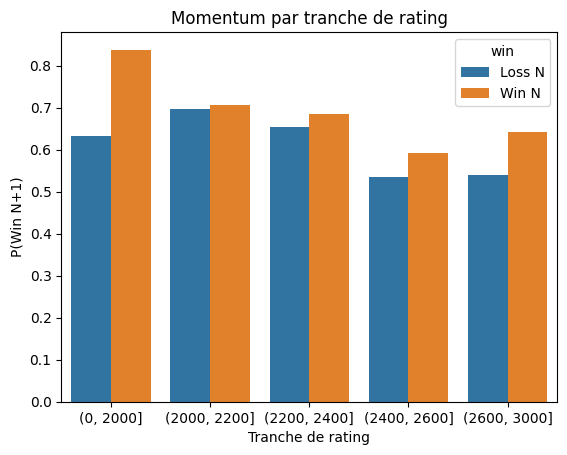

In [93]:
# Reformater pour seaborn
df_plot = (
    df_all.dropna(subset=["win_next"])
          .groupby(["rating_bin", "win"])["win_next"]
          .mean()
          .reset_index()
)
df_plot["win"] = df_plot["win"].map({0:"Loss N", 1:"Win N"})

sns.barplot(x="rating_bin", y="win_next", hue="win", data=df_plot)
plt.ylabel("P(Win N+1)")
plt.xlabel("Tranche de rating")
plt.title("Momentum par tranche de rating")
plt.xticks(rotation=0)
plt.show()


# Un joueur qui gagne refait-il la même ouverture ?

In [105]:
import pandas as pd
from scipy.stats import chi2_contingency

# --- 1️⃣ Créer la colonne "same_opening_next" ---
df_all = df_all.sort_values(["user_id", "timestamp"]).reset_index(drop=True)
df_all["same_opening_next"] = (
    df_all.groupby("user_id")["opening_name"].shift(-1) == df_all["opening_name"]
).astype(int)

# Filtrer lignes valides (où on peut calculer next opening)
df_valid = df_all.dropna(subset=["same_opening_next"])

# --- 2️⃣ Probabilités globales ---
prob_same_by_result = df_valid.groupby("win")["same_opening_next"].mean()
print("Probabilité de rejouer la même ouverture selon résultat N :")
print(prob_same_by_result)

# --- 3️⃣ Test χ² global ---
table_global = pd.crosstab(df_valid["win"], df_valid["same_opening_next"])
chi2, p_value, _, _ = chi2_contingency(table_global)
print("\nTest χ² global :")
print(table_global)
print("p-value :", p_value)

# --- 4️⃣ Analyse par type de partie ---
results_by_format = {}
for fmt, df_fmt in df_valid.groupby("format_partie"):
    table_fmt = pd.crosstab(df_fmt["win"], df_fmt["same_opening_next"])
    if table_fmt.shape == (2,2):
        chi2, p, _, _ = chi2_contingency(table_fmt)
        prob_fmt = df_fmt.groupby("win")["same_opening_next"].mean()
        results_by_format[fmt] = {
            "table": table_fmt,
            "probabilities": prob_fmt,
            "p_value": p
        }

# Afficher les résultats par format
for fmt, res in results_by_format.items():
    print(f"\nFormat : {fmt}")
    print("Table de contingence :\n", res["table"])
    print("Probabilités :", res["probabilities"].to_dict())
    print("p-value :", res["p_value"])

Probabilité de rejouer la même ouverture selon résultat N :
win
0    0.147280
1    0.143618
Name: same_opening_next, dtype: float64

Test χ² global :
same_opening_next     0    1
win                         
0                  3057  528
1                  4824  809
p-value : 0.6480658263123071

Format : blitz
Table de contingence :
 same_opening_next     0    1
win                         
0                   869  110
1                  1245  169
Probabilités : {0: 0.11235955056179775, 1: 0.11951909476661952}
p-value : 0.6370809945267066

Format : bullet
Table de contingence :
 same_opening_next     0    1
win                         
0                   797  194
1                  1193  216
Probabilités : {0: 0.19576185671039353, 1: 0.1533002129169624}
p-value : 0.007670916077650644

Format : classical
Table de contingence :
 same_opening_next     0    1
win                         
0                   612   95
1                  1261  202
Probabilités : {0: 0.13437057991513437, 1: 0.

On remarque que la p-value du test "Il y a dépendance entre gain à la partie N et ouverture rejouée en N+1" est plus significative pour les parties courtes, signe que les joueurs joue davantage à l'instinct.

# Retraitement de l'analyse principale 
On cherche à n'étudier que des streaks de parties qui se suivent réellement (c'est-à-dire pas seulement des parties consécutives - et potentiellement espacées de plusieurs jours-, mais rapprochées dans le temps).

In [109]:
import pandas as pd

# S'assurer que timestamp est en datetime
df_all["date"] = pd.to_datetime(df_all["timestamp"], unit='ms')

# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Fonction pour calculer les streaks avec durée maximale paramétrable et format_partie
def streaks_with_time_by_format(df, max_gap_hours):
    streaks = []
    if df.empty:
        return streaks
    
    prev_win = df.iloc[0]["win"]
    prev_time = df.iloc[0]["date"]
    prev_format = df.iloc[0]["format_partie"]
    count = 1
    
    for idx, row in df.iloc[1:].iterrows():
        delta = (row["date"] - prev_time).total_seconds() / 3600
        if (row["win"] == prev_win) and (delta <= max_gap_hours) and (row["format_partie"] == prev_format):
            count += 1
        else:
            if count >= 2:
                streaks.append((prev_win, prev_format, count))
            count = 1
            prev_win = row["win"]
            prev_format = row["format_partie"]
        prev_time = row["date"]
    
    # Vérifier le dernier streak
    if count >= 2:
        streaks.append((prev_win, prev_format, count))
        
    return streaks

# Durée maximale choisie par l'utilisateur
max_gap_hours = float(input("Entrez la durée maximale entre parties pour considérer un streak (en heures) : "))

# Appliquer à tous les joueurs
all_streaks = []
for user, df_user in df_all.groupby("user_id"):
    streaks = streaks_with_time_by_format(df_user, max_gap_hours=max_gap_hours)
    all_streaks.extend(streaks)

# Convertir en DataFrame
streak_df = pd.DataFrame(all_streaks, columns=["win", "format_partie", "length"])

# Tableau descriptif par type de partie et résultat
table_by_format = streak_df.groupby(["format_partie", "win"])["length"].describe()

print("\nStatistiques des streaks (longueur >= 2) par type de partie et résultat :")
print(table_by_format)


Statistiques des streaks (longueur >= 2) par type de partie et résultat :
                   count      mean       std  min  25%  50%  75%   max
format_partie win                                                     
blitz         0    218.0  2.724771  1.304876  2.0  2.0  2.0  3.0  11.0
              1    329.0  3.452888  1.993526  2.0  2.0  3.0  4.0  16.0
bullet        0    209.0  3.248804  1.920364  2.0  2.0  3.0  4.0  17.0
              1    294.0  3.846939  3.208411  2.0  2.0  3.0  4.0  36.0
classical     0     88.0  2.250000  0.551904  2.0  2.0  2.0  2.0   5.0
              1    279.0  3.039427  1.550779  2.0  2.0  2.0  4.0  12.0
rapid         0    178.0  2.539326  1.084625  2.0  2.0  2.0  3.0  10.0
              1    308.0  2.935065  1.656791  2.0  2.0  2.0  3.0  12.0


C'est cohérent avec l'intuition, on pourrait penser qu'une suite de défaites incite le joueur à se décourager et arrêter de jouer.
Les statistiques sont aussi cohérentes : on observe une longueur maximale de streak plus courte pour les parties de type long comme classical.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Trier par joueur et date
df_all = df_all.sort_values(["user_id", "date"]).reset_index(drop=True)

# Calculer delta_hours entre parties consécutives
df_all["delta_hours"] = df_all.groupby("user_id")["date"].diff().dt.total_seconds() / 3600

# Créer win_next pour toutes les parties (sans limite de temps)
df_all["win_next_brut"] = df_all.groupby("user_id")["win"].shift(-1)

# Demander la limite de temps pour "streak rapide"
max_gap_hours = float(input("Entrez la durée maximale entre parties pour considérer N → N+1 (en heures) : "))

# Créer win_next limité par delta_hours
def compute_win_next_limited(df, max_gap_hours):
    df = df.copy()
    df["win_next_limited"] = df["win"].shift(-1)
    df["delta_next_hours"] = df["date"].shift(-1) - df["date"]
    df["delta_next_hours"] = df["delta_next_hours"].dt.total_seconds() / 3600
    df.loc[df["delta_next_hours"] > max_gap_hours, "win_next_limited"] = pd.NA
    return df

df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)

# Supprimer les NaN
df_clean_brut = df_all.dropna(subset=["win_next_brut"])
df_clean_limited = df_all.dropna(subset=["win_next_limited"])

# Stocker les résultats
results_by_format = []

for fmt in df_all["format_partie"].unique():
    # Table brute
    df_fmt_brut = df_clean_brut[df_clean_brut["format_partie"] == fmt]
    table_brut = pd.crosstab(df_fmt_brut["win"], df_fmt_brut["win_next_brut"])
    _, p_value_brut, _, _ = chi2_contingency(table_brut)

    # Table limitée
    df_fmt_lim = df_clean_limited[df_clean_limited["format_partie"] == fmt]
    table_lim = pd.crosstab(df_fmt_lim["win"], df_fmt_lim["win_next_limited"])
    _, p_value_limited, _, _ = chi2_contingency(table_lim)

    results_by_format.append({
        "format_partie": fmt,
        "p_value_brute": p_value_brut,
        "p_value_limited": p_value_limited
    })

# Résumé
summary_df = pd.DataFrame(results_by_format)
print("\nComparaison p-values par type de partie (brut vs limité par delta_hours) :")
print(summary_df)


Comparaison p-values par type de partie (brut vs limité par delta_hours) :
  format_partie  p_value_brut  p_value_limited
0     classical  1.714185e-01     2.493356e-01
1         blitz  3.902725e-04     1.078099e-03
2        bullet  7.143236e-11     1.229232e-11
3         rapid  7.515301e-07     3.720122e-06


/tmp/ipykernel_14304/1229777311.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby("user_id").apply(lambda x: compute_win_next_limited(x, max_gap_hours)).reset_index(drop=True)
